# Elections 2020 (constitution)

In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import pickle

sns.set(context='paper', style='ticks', font='DejaVu Sans')

In [2]:
data = pd.read_csv('../data/2020.csv.zip')
voters = data['Число участников голосования, включенных в список участников голосования на момент окончания голосования'].values
given =  data['Число бюллетеней, выданных участникам голосования'].values
received = data['Число бюллетеней, содержащихся в ящиках для голосования'].values
leader = data['ДА'].values

print(np.sum(~np.isnan(leader)))

reg = data['reg'].values
tik = data['tik'].values

96765


<IPython.core.display.Javascript object>


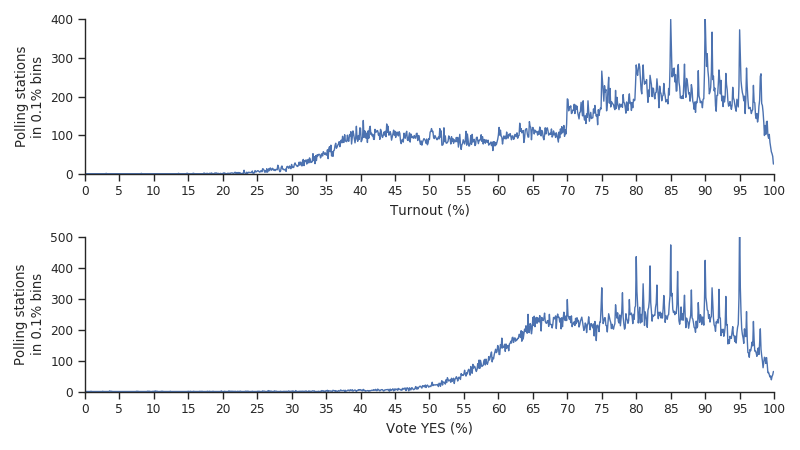

In [3]:
year = 2020
binwidth = 0.1         # Bin width (in percentage points)
addNoise = True        # If add U(-0.5,0.5) noise to the nominators (to remove division artifacts)
weights  = 'off'       # Weights: can be 'off'     (counts polling stations), 
                       #                 'voters'  (counts registered voters),
                       #                 'given'   (counts given ballots)
                       #                 'leader'  (counts ballots for the leader)
minSize  = 0           # Exclude polling stations with number of voters less than minSize

# Settings used in our papers:
# * AOAS-2016:         binwidth=0.1,  addNoise=False, weights='voters', minSize = 0
# * Significance-2016: binwidth=0.25, addNoise=True,  weights='off'     minSize = 0
# * Significance-2018: binwidth=0.1,  addNoise=True,  weights='off'     minSize = 0

######################################################################################

ind = ~np.isnan(received) & (received > 0) & (given < voters) & (voters >= minSize)# & np.array(['Нальчик' in t for t in tik])# & (reg=='город Москва')
edges = np.arange(-binwidth/2, 100+binwidth/2, binwidth)
centers = np.arange(0,100,binwidth)

np.random.seed(42)
noise = np.zeros(np.sum(ind)) if not addNoise else np.random.rand(np.sum(ind)) - .5

w = None
if weights == 'voters': w = voters[ind]
if weights == 'given':  w = given[ind]
if weights == 'leader': w = leader[ind]
h1 = np.histogram(100 * (given[ind]+noise)/voters[ind],    bins=edges, weights = w)[0]
h2 = np.histogram(100 * (leader[ind]+noise)/received[ind], bins=edges, weights = w)[0]

ylbl = 'Polling stations'
if weights == 'voters': ylbl = 'Voters'
if weights == 'given':  ylbl = 'Ballots given'
if weights == 'leader': ylbl = 'Ballots for leader'


plt.figure(figsize=(8,4.5))
plt.subplot(211)
plt.plot(centers, h1, linewidth=1)
plt.xlabel("Turnout (%)")
plt.ylabel('{}\nin {}% bins'.format(ylbl, binwidth))
plt.xticks(np.arange(0,101,5))
# plt.title('Russian election {}'.format(year))
plt.xlim([0,100])
plt.ylim([0,400])
# plt.gca().xaxis.grid(True)

plt.subplot(212)
plt.plot(centers, h2, linewidth=1)
plt.xlabel("Vote YES (%)")
plt.ylabel('{}\nin {}% bins'.format(ylbl, binwidth))
plt.xticks(np.arange(0,101,5))
plt.xlim([0,100])
plt.ylim([0,500])
# plt.gca().xaxis.grid(True)

sns.despine()
plt.tight_layout()
plt.savefig('peaks2020.png', dpi=200)

In [3]:
# Monte Carlo simulations

import time

def anomaly(voters, given, received, leader, nrep=1000, prctl = 99.9, seed=42, 
            binwidth = .1, period = 1):
    
    # inclusion criteria that we used in the AOAS paper
    ind = (received > 0) & (voters >= 100)
    indd = (given[ind]/voters[ind] <= .99) & (leader[ind]/received[ind] <= .99)
    ind[np.where(ind)[0][~indd]] = False    
    
    p1 = 100 * leader[ind]/received[ind]
    p2 = 100 * given[ind]/voters[ind]
    
    # first dimension:  overall / only result / only turnout
    # second dimension: number of stations, voters, given ballots, leader's ballots
    integer = np.zeros((3,4)) 
    for i,weights in enumerate([np.ones_like(voters), voters, given, leader]):
        w = weights[ind]
        integer[0,i] = np.sum(w[(np.abs(p1 - np.round(p1/period)*period)  <= binwidth/2) | 
                                (np.abs(p2 - np.round(p2/period)*period)  <= binwidth/2)])
        integer[1,i] = np.sum(w[ np.abs(p1 - np.round(p1/period)*period)  <= binwidth/2])
        integer[2,i] = np.sum(w[ np.abs(p2 - np.round(p2/period)*period)  <= binwidth/2])

    t = time.time()    
    leader_binom = np.zeros((nrep, np.sum(ind)))
    given_binom  = np.zeros((nrep, np.sum(ind)))
    np.random.seed(seed)
    for n in range(np.sum(ind)):
        if n%1000 == 0:
            print('.', end='')
        leader_binom[:,n] = np.random.binomial(n=received[ind][n], 
                                               p=leader[ind][n]/received[ind][n], 
                                               size=nrep)
        given_binom[:,n]  = np.random.binomial(n=voters[ind][n],   
                                               p=given[ind][n] /voters[ind][n],   
                                               size=nrep)
    t = time.time() - t
    m,s = divmod(t, 60)
    print('{:2.0f}m {:2.0f}s'.format(m,s))
    
    p1 = 100 * leader_binom/received[ind]
    p2 = 100 * given_binom/voters[ind]    
    integer_mc = np.zeros((3,4,nrep)) 
    for i,weights in enumerate([np.ones_like(voters), voters, given, leader]):
        w = weights[ind]
        integer_mc[0,i,:] = np.sum(w * ((np.abs(p1 - np.round(p1/period)*period) <= binwidth/2) | 
                                        (np.abs(p2 - np.round(p2/period)*period) <= binwidth/2)), axis=1)
        integer_mc[1,i,:] = np.sum(w *  (np.abs(p1 - np.round(p1/period)*period) <= binwidth/2), axis=1)
        integer_mc[2,i,:] = np.sum(w *  (np.abs(p2 - np.round(p2/period)*period) <= binwidth/2), axis=1)  
        
    d = integer - np.mean(integer_mc, axis=2) 
    s = np.std(integer_mc, axis=2)
    q = np.percentile(integer_mc, prctl, axis=2) - np.mean(integer_mc, axis=2)
    return (d,s,q)  # anomaly, MC std, MC percentile

In [4]:
anomaly2020 = anomaly(voters, given, received, leader)

........................................................................................... 1m 28s


In [6]:
with open('../significance2018/montecarlo.pickle', 'rb') as f:
    [anomalies, stds, prctls] = pickle.load(f)
    
anomalies = np.concatenate((anomalies, anomaly2020[0][np.newaxis,:,:]))
stds = np.concatenate((stds, anomaly2020[1][np.newaxis,:,:]))
prctls = np.concatenate((prctls, anomaly2020[2][np.newaxis,:,:]))

years = np.array([2000, 2003, 2004, 2007, 2008, 2011, 2012, 2016, 2018, 2020])

print(anomalies[:,0,0])

[ 108.577   84.458  933.748  722.725 1722.779 1003.477 1159.585 1502.391
 1708.839 3675.201]


<IPython.core.display.Javascript object>


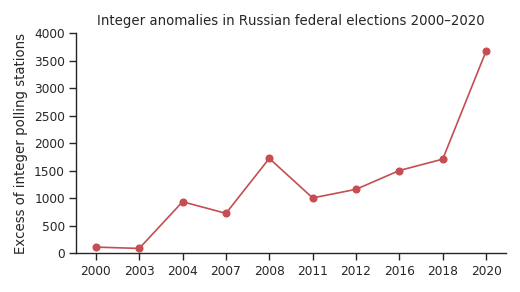

In [21]:
plt.figure(figsize=(8 * 0.65, 4.5 * 0.65))
plt.plot(anomalies[:,0,0], '-o', color='r')
plt.ylabel('Excess of integer polling stations')
plt.title('Integer anomalies in Russian federal elections 2000–2020')
plt.ylim([0, 4000])
plt.xticks(np.arange(years.size), years)
sns.despine()
plt.tight_layout()

plt.savefig('integer-anomalies.png', dpi=200)

<IPython.core.display.Javascript object>


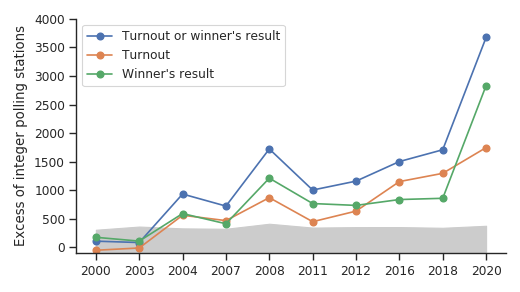

In [24]:
plt.figure(figsize=(8 * 0.65, 4.5 * 0.65))

plt.plot(anomalies[:,0,0], '-o')
plt.plot(anomalies[:,2,0], '-o')
plt.plot(anomalies[:,1,0], '-o')
# plt.plot(prctls[:,0,0], '-', color=[.4,.4,.4], linewidth=.5)
plt.fill_between(np.arange(len(years)), plt.ylim()[0], prctls[:,0,0], color=[.8,.8,.8])
plt.legend(("Turnout or winner's result", "Turnout", "Winner's result"))
plt.ylabel('Excess of integer polling stations')
plt.ylim([-100, 4000])
plt.xticks(np.arange(years.size), years)
sns.despine()
plt.tight_layout()

plt.savefig('integer-anomalies-all.png', dpi=200)

## 2D histograms

<IPython.core.display.Javascript object>


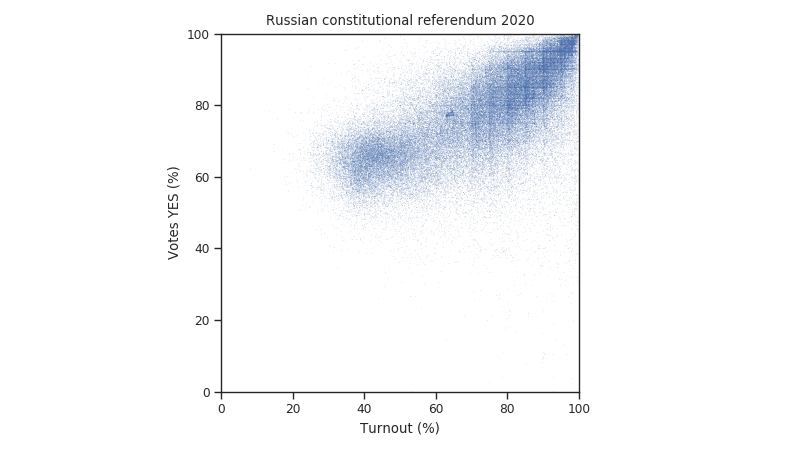

In [170]:
ind = ~np.isnan(received) & (received > 0) & (given < voters)

v = given[ind]/voters[ind] * 100
p = leader[ind]/received[ind] * 100

plt.figure(figsize=(8,4.5))
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(v,p, s=.2, alpha=.5, edgecolor='none')
plt.xlim([0,100])
plt.ylim([0,100])
plt.xlabel('Turnout (%)')
plt.ylabel('Votes YES (%)')
plt.title('Russian constitutional referendum 2020')

plt.tight_layout()
plt.savefig('comet.png', dpi=200)

<IPython.core.display.Javascript object>


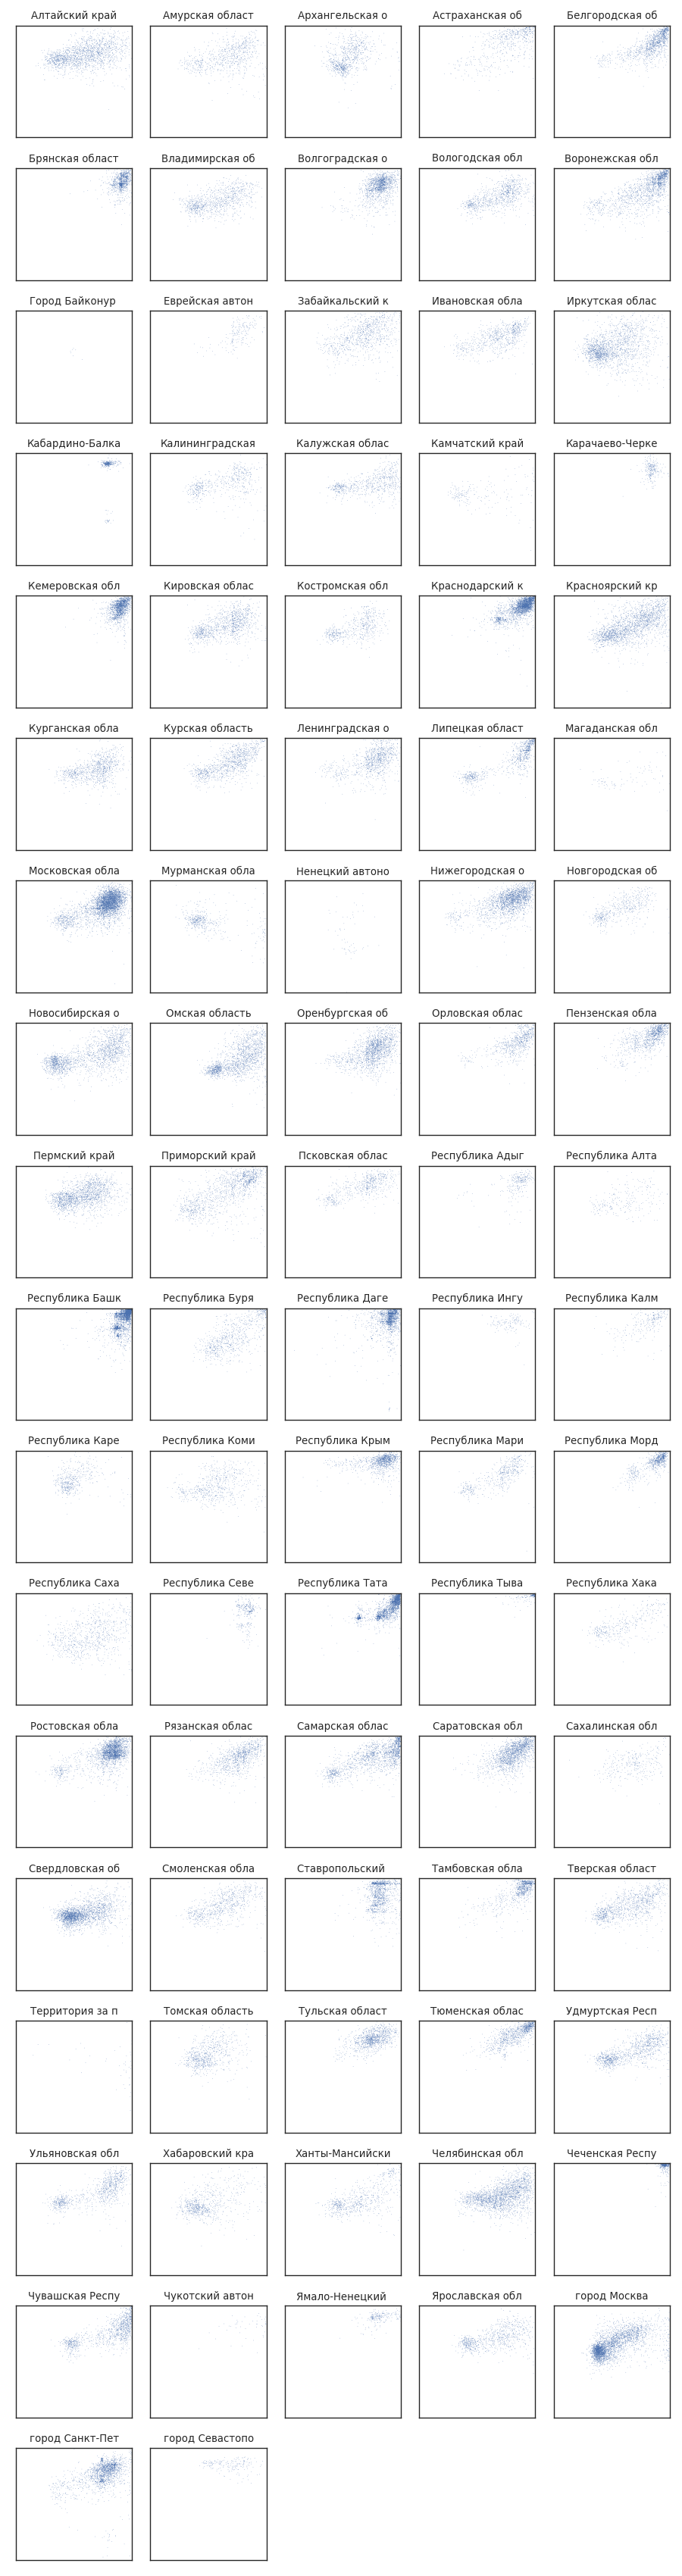

In [168]:
ind = ~np.isnan(received) & (received > 0) & (given < voters)

v = given[ind]/voters[ind]
p = leader[ind]/received[ind]

regs = np.unique(reg)

plt.figure(figsize=(9,34))
for i,r in enumerate(np.unique(regs)):
    plt.subplot(18,5,i+1)
    plt.title(r[:15])
    ind2 = (reg == r)
    ind2 = ind2[ind]

    plt.scatter(v[ind2],p[ind2], s=.2, edgecolors='none')#, s=.1, alpha=.3)
    plt.xlim([0,1])
    plt.ylim([0,1])

    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.savefig('regions.png', dpi=100)

<IPython.core.display.Javascript object>


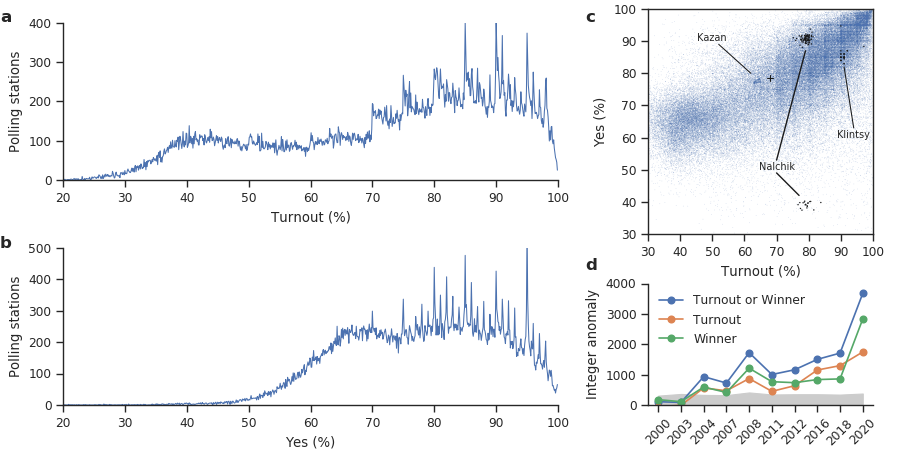

In [8]:
fig = plt.figure(figsize=(9, 4.5))

binwidth = 0.1
ind = ~np.isnan(received) & (received > 0) & (given < voters)
edges = np.arange(-binwidth/2, 100+binwidth/2, binwidth)
centers = np.arange(0,100,binwidth)

np.random.seed(42)
noise = np.random.rand(np.sum(ind)) - .5

h1 = np.histogram(100 * (given[ind]+noise)/voters[ind],    bins=edges)[0]
h2 = np.histogram(100 * (leader[ind]+noise)/received[ind], bins=edges)[0]

ax1 = plt.axes([.07,.6,.55,.35])
plt.plot(centers, h1, linewidth=.75)
plt.xlabel("Turnout (%)")
plt.ylabel('Polling stations')
plt.xticks(np.arange(0,101,10))#,['']*10)
plt.yticks([0,100,200,300,400])
plt.xlim([20,100])
plt.ylim([0,400])

ax2 = plt.axes([.07,.1,.55,.35])
plt.plot(centers, h2, linewidth=.75)
plt.xlabel("Yes (%)")
plt.ylabel('Polling stations')
plt.xticks(np.arange(0,101,10))
plt.xlim([20,100])
plt.ylim([0,500])

v = given[ind]/voters[ind] * 100
p = leader[ind]/received[ind] * 100

ax3 = plt.axes([.72,.44,.25,.58])
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(v,p, s=.2, alpha=.4, edgecolor='none', rasterized=True)
plt.xlim([30,100])
plt.ylim([30,100])
plt.xticks(np.arange(30,101,10))
plt.xlabel('Turnout (%)')#, labelpad=-30)
plt.ylabel('Yes (%)')#, labelpad=-40)
# ax3.tick_params(axis="x",direction="in")#, pad=-22)
# ax3.tick_params(axis="y",direction="in")
# plt.title('Russian constitutional referendum 2020')

ind2 = ind & np.array(['Нальчик' in t for t in tik])
v = given[ind2]/voters[ind2] * 100
p = leader[ind2]/received[ind2] * 100
# ind2[np.where(ind2)[0][p>50]] = False
v = given[ind2]/voters[ind2] * 100
p = leader[ind2]/received[ind2] * 100
# plt.gca().set_prop_cycle(None)
plt.scatter(v,p, s=1, edgecolors='none', color='k')#, s=.1, alpha=.3)

# ind2 = ind & np.array(['Казань,' in t for t in tik])
# v = given[ind2]/voters[ind2] * 100
# p = leader[ind2]/received[ind2] * 100
# # plt.gca().set_prop_cycle(None)
# plt.scatter(v,p, s=.2, edgecolors='none', color='k')#, s=.1, alpha=.3)

ind2 = ind & np.array(['Клинцовская городская' in t for t in tik])
v = given[ind2]/voters[ind2] * 100
p = leader[ind2]/received[ind2] * 100
# plt.gca().set_prop_cycle(None)
plt.scatter(v,p, s=1, edgecolors='none', color='k')#, s=.1, alpha=.3)

dx = 1
plt.plot([67.9-dx, 67.9+dx], [78.6, 78.6], 'k', linewidth=.75)
plt.plot([67.9, 67.9], [78.6-dx, 78.6+dx], 'k', linewidth=.75)

plt.text(50, 90,'Kazan', fontsize=7, ha='center')
plt.plot([52,62],[89,80], 'k', linewidth=.75)

plt.text(94, 60,'Klintsy', fontsize=7, ha='center')
plt.plot([94,91],[63,82], 'k', linewidth=.75)

plt.text(70, 50,'Nalchik', fontsize=7, ha='center')
plt.plot([70,79],[53,87], 'k', linewidth=1)
plt.plot([70,77],[49,42], 'k', linewidth=1)


ax4 = plt.axes([.72,.1,.25,.27])
plt.plot(anomalies[:,0,0], '-o')
plt.plot(anomalies[:,2,0], '-o')
plt.plot(anomalies[:,1,0], '-o')
plt.fill_between(np.arange(len(years)), plt.ylim()[0], prctls[:,0,0], color=[.8,.8,.8])
plt.legend(("Turnout or Winner", "Turnout", "Winner"),
           frameon=False)
plt.ylabel('Integer anomaly')
plt.ylim([0, 4000])
plt.xticks(np.arange(years.size), years, rotation=45)

# ax5 = plt.axes([.85,.65,.1,.3])
# plt.gca().set_aspect('equal', adjustable='box')
# ind2 = ind & (reg == 'Кабардино-Балкарская Республика')
# ind2 = ind & np.array(['Нальчик' in t for t in tik])
# v = given[ind2]/voters[ind2] * 100
# p = leader[ind2]/received[ind2] * 100
# plt.scatter(v,p, s=1, edgecolors='none')#, s=.1, alpha=.3)
# plt.xlim([30,100])
# plt.ylim([30,100])
# plt.xticks([])
# plt.yticks([])
# plt.title('Kabardino-Balkaria')

# ax6 = plt.axes([.85,.35,.1,.3])
# plt.gca().set_aspect('equal', adjustable='box')
# ind2 = ind & np.array(['Клинцовская городская' in t for t in tik])
# # ind2 = ind & (reg == 'Брянская область')
# v = given[ind2]/voters[ind2] * 100
# p = leader[ind2]/received[ind2] * 100
# plt.scatter(v,p, s=2, edgecolors='none')#, s=.1, alpha=.3)
# plt.xlim([80,100])
# plt.ylim([80,100])
# plt.xticks([])
# plt.yticks([])
# plt.title('Klintsy')

# ax7 = plt.axes([.85,.05,.1,.3])
# plt.gca().set_aspect('equal', adjustable='box')
# ind2 = ind & (reg == 'Кабардино-Балкарская Республика')
# v = given[ind2]/voters[ind2] * 100
# p = leader[ind2]/received[ind2] * 100
# plt.scatter(v,p, s=1, edgecolors='none')#, s=.1, alpha=.3)
# plt.xlim([0,100])
# plt.ylim([0,100])
# plt.xticks([])
# plt.yticks([])
# plt.title('Kabardino-Balkaria')

sns.despine(ax=ax1)
sns.despine(ax=ax2)
sns.despine(ax=ax4)
# plt.tight_layout()

fig.text(0,.95,'a', fontsize=12, fontweight='bold')
fig.text(0,.45,'b', fontsize=12, fontweight='bold')
fig.text(.65,.95,'c', fontsize=12, fontweight='bold')
fig.text(.65,.40,'d', fontsize=12, fontweight='bold')

plt.savefig('significance2020.png', dpi=300)
plt.savefig('significance2020-scatterBitmap.pdf', dpi=600)